## Instalaciones

In [ ]:
%pip install openpyxl
%pip install pandas
%pip install seaborn
%pip install matplot
%pip install scikit-learn
%pip install ipykernel
%pip install wordcloud

## Librerias

In [ ]:
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import re, unicodedata
from collections import Counter

## Preprocesamiento

In [3]:
df = pd.read_excel("Consolidado_GPON_Final-1.xlsx", engine='openpyxl')

In [8]:
df.head(1)

,Source.Name,Tarea,UNEPEDIDO,TASKTYPECATEGORY,UNEMUNICIPIO,UNEPRODUCTOS,ENGINEER_ID,USER_ID_FIREBASE,USER_IDENTIFICATION_FIREBASE,FECHA_SOLICITUD_FIREBASE,...,ASA,Tiempo de gestión,Mes,Dia,Año,Area,Region,Concatenar,N veces,Original
0,Formulario GPON ABRIL 2025.xlsx,17577186,PED1,Aseguramiento,Riohacha,NaN,EN_ID1,igomezfruif,UIF11188551151,2025-04-06 15:47:14,...,0.000972,0.004132,abril,6,2025,Otros_Municipios_Norte,COSTA,6SA-7577186,1,SA-7577186


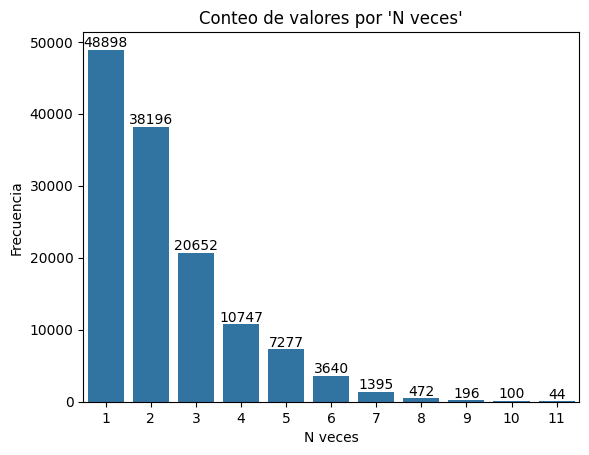

In [7]:
ax = sns.countplot(data=df, x="N veces")
plt.xlabel("N veces")
plt.ylabel("Frecuencia")
plt.title("Conteo de valores por 'N veces'")

# Mostrar los valores encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.show()

In [ ]:
#Conteo de palabras para cada observación de terreno

df["conteo_palabras"] = df["OBSERVACION TERRENO"].str.split().str.len()

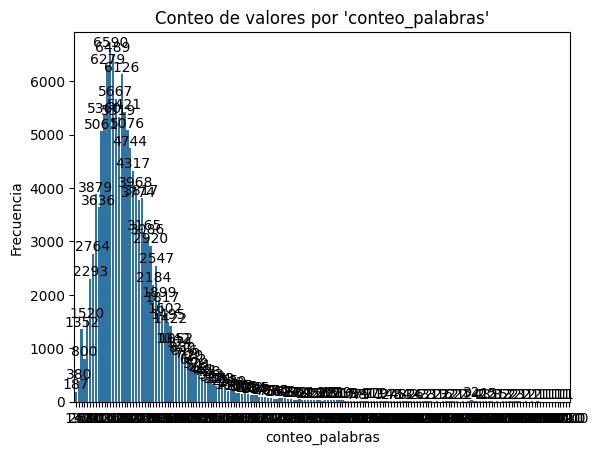

In [19]:
ax = sns.countplot(data=df, x="conteo_palabras")
plt.xlabel("conteo_palabras")
plt.ylabel("Frecuencia")
plt.title("Conteo de valores por 'conteo_palabras'")

# Mostrar los valores encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.show()

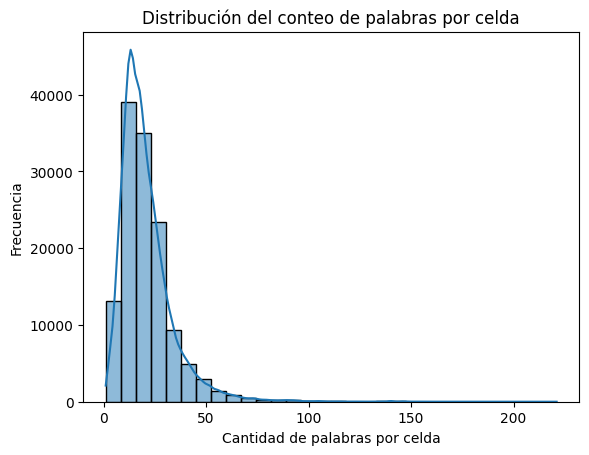

In [ ]:
sns.histplot(df["conteo_palabras"], bins=30, kde=True)
plt.xlabel("Cantidad de palabras por celda")
plt.ylabel("Frecuencia")
plt.title("Distribución del conteo de palabras por celda")
plt.show()

In [ ]:
#POR SI LO QUEREMOS HACER MANUIALMENTE MONOGRAMA

# import pandas as pd
# from collections import Counter
# import re

# # Leer archivo Excel

# # Unir todo el texto
# texto = " ".join(df["OBSERVACION TERRENO"].dropna().astype(str)).lower()

# # Lista de palabras a excluir (stopwords + cortesía)
# stop = {
#     "el","la","los","las","un","una","unos","unas","de","del","a","en","y","o","u","que","con","por","para","se",
#     "al","su","sus","lo","le","les","es","son","como","ya","no","si","más","pero","cuando","sin","sobre","hasta",
#     "me","favor","gracias","hola","buenos","buenas","dias","tardes","noches","sr","sra","porfavor","por","favor"
# }

# # Limpiar, dividir y filtrar palabras
# palabras = [p for p in re.findall(r'\b[a-záéíóúñü]+\b', texto) if p not in stop]

# # Contar frecuencia
# top_20 = Counter(palabras).most_common(20)
# top_20_df = pd.DataFrame(top_20, columns=["Palabra", "Frecuencia"])
# print(top_20_df)

In [ ]:
#POR SI LO QUEREMOS HACER MANUIALMENTE TRIGRAMA

# import re, unicodedata
# import pandas as pd
# from collections import Counter

# # stopwords mínimas + cortesía
# stop = {"el","la","los","las","un","una","unos","unas","de","del","a","en","y","o","u","que","con","por","para",
#         "se","su","sus","lo","al","ya","no","si","mas","pero","cuando","sin","sobre","hasta","me","favor","gracias",
#         "hola","buenos","buenas","dias","tardes","noches","sr","sra","porfavor","por","favor"}

# def strip_acc_keep_enye(s):
#     s = str(s).lower().replace("ñ","{enye}")
#     s = unicodedata.normalize("NFKD", s)
#     s = "".join(ch for ch in s if not unicodedata.combining(ch))
#     return s.replace("{enye}","ñ")

# def tokens(s):
#     s = strip_acc_keep_enye(s)
#     s = re.sub(r"[^a-zñü\s]", " ", s)
#     return [w for w in s.split() if len(w)>=3 and w not in stop]

# # tokens por fila
# tok = df["OBSERVACION TERRENO"].dropna().map(tokens)

# # trigramas (con acentos ya normalizados)
# tris = [" ".join(t[i:i+3]) for t in tok for i in range(len(t)-2)]

# top50 = pd.DataFrame(Counter(tris).most_common(50), columns=["Trigrama","Frecuencia"])
# print(top50)


In [ ]:
# NO ELIMINA, ESTE VA

def norm_keep_enye(s):
    s = str(s).lower().replace("ñ","{ny}")
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch)).replace("{ny}","ñ")
    return re.sub(r"[^a-zñü\s]+"," ", s).strip()

def toks(s):  # permitimos artículos/conectores
    return re.findall(r"[a-zñü]+", norm_keep_enye(s))

# patrones de cortesía a filtrar
pats = [re.compile(rx) for rx in [
    r'^(buen|buenos|buenas)\s+(dia|dias|tardes|noches)\b',
    r'\b(dia|dias|tardes|noches)\s+por\s+favor\b',
    r'\bdias\s+me\s+(colaboran|colabora)\b',
    r'\bpor\s+favor\b',                 # cualquier "por favor"
    r'\bfavor\b',                       # “favor …”
    r'^me\s+(colaboras|colaboran|colabora|ayuda|colabore|puede|pueden)\s+(con|por)\b',
    r'\bgracias\b',
    r'\bya\s+que\s+(no|el|si|)\b',
    # ---- NUEVOS FILTROS SOLICITADOS ----
    r'\bcompa(?:ñ|n)?(?:ero|er@)?\s+me\s+colabora(?:s|n)?\b',  # "compañero me colabora(s/n)"
    r'\bcompa(?:ñ|n)?(?:ero|er@)?\b',                          # "compañer@", "compa", "compañero"
    r'\bme\s+colabora(?:s|n)?\b',                              # "me colabora(s/n)"
    r'\b(dia|dias|tardes|noches)\s+me\s+colabora(?:s|n)?\b',   # "dias/tardes me colabora(s)"
    r'\btardes\s+compa(?:ñ|n)?(?:ero|er@)?\s+me\b',            # "tardes compañero me"
]]

def es_cortesia(tri):  # descarta si coincide con algún patrón
    return any(p.search(tri) for p in pats)

tok = df["OBSERVACION TERRENO"].dropna().map(toks)
tris = [" ".join(t[i:i+3]) for t in tok for i in range(len(t)-2)]
tris = [tri for tri in tris if not es_cortesia(tri)]  # quitar cortesía

top60 = pd.DataFrame(Counter(tris).most_common(60), columns=["Trigrama","Frecuencia"])
print(top60)

top60_to_excel = top60.to_excel("top60_trigramas_utiles.xlsx", index=False)

                             Trigrama  Frecuencia
0                      arpon nap hilo       27012
1                    ip de navegacion       15920
2                      sale arpon nap        8169
3                     entra arpon nap        8009
4                   estabilizar pon y        6568
5                           de la ont        5557
6                        el cambio de        5435
7                          nap hilo y        5377
8                      nap hilo entra        4690
9           cambio de infraestructura        4260
10                      con el cambio        4035
11                   hilo entra arpon        3741
12         infraestructura sale arpon        3451
13                      sale nap hilo        2960
14                 realizar cambio de        2954
15                    de navegacion y        2804
16                     entra nap hilo        2769
17                        pon y subir        2768
18                 estabilizar el pon        2690


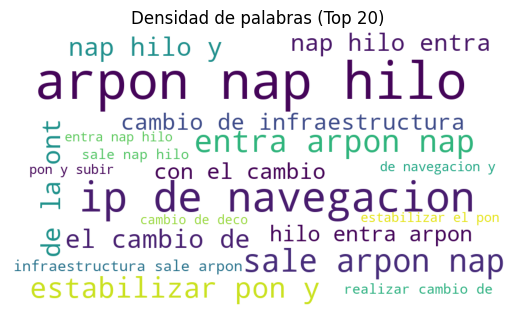

In [ ]:
freqs = dict(zip(top20["Trigrama"], top20["Frecuencia"]))

try:
    from wordcloud import WordCloud
    wc = WordCloud(width=900, height=500, background_color="white").generate_from_frequencies(freqs)
    plt.imshow(wc); plt.axis("off"); plt.title("Densidad de palabras (Top 20)"); plt.show()
except Exception:
    # Fallback: barras (frecuencia ~ densidad visual)
    top20_sorted = top20.sort_values("Frecuencia")
    plt.figure(figsize=(10,5))
    plt.barh(top20_sorted["Trigrama"], top20_sorted["Frecuencia"])
    plt.title("Densidad de palabras (Top 20)")
    plt.xlabel("Frecuencia"); plt.tight_layout(); plt.show()
